<a href="https://colab.research.google.com/github/sakki221/Capstone-project/blob/main/Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Upload CSV file
from google.colab import files
uploaded = files.upload()  # Upload your dataset.csv here

# Step 2: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

filename = list(uploaded.keys())[0]  # get the uploaded file name
df = pd.read_csv(filename)

# Optional: make column names lowercase for consistency
df.columns = [c.lower() for c in df.columns]

# Display the first few rows
df.head()


Saving dataset.csv to dataset.csv


,id,systemcodenumber,capacity,latitude,longitude,occupancy,vehicletype,trafficconditionnearby,queuelength,isspecialday,lastupdateddate,lastupdatedtime
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,low,1,0,04-10-2016,08:25:00
2,2,BHMBCCMKT01,577,26.144536,91.736172,80,car,low,2,0,04-10-2016,08:59:00
3,3,BHMBCCMKT01,577,26.144536,91.736172,107,car,low,2,0,04-10-2016,09:32:00
4,4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,low,2,0,04-10-2016,09:59:00


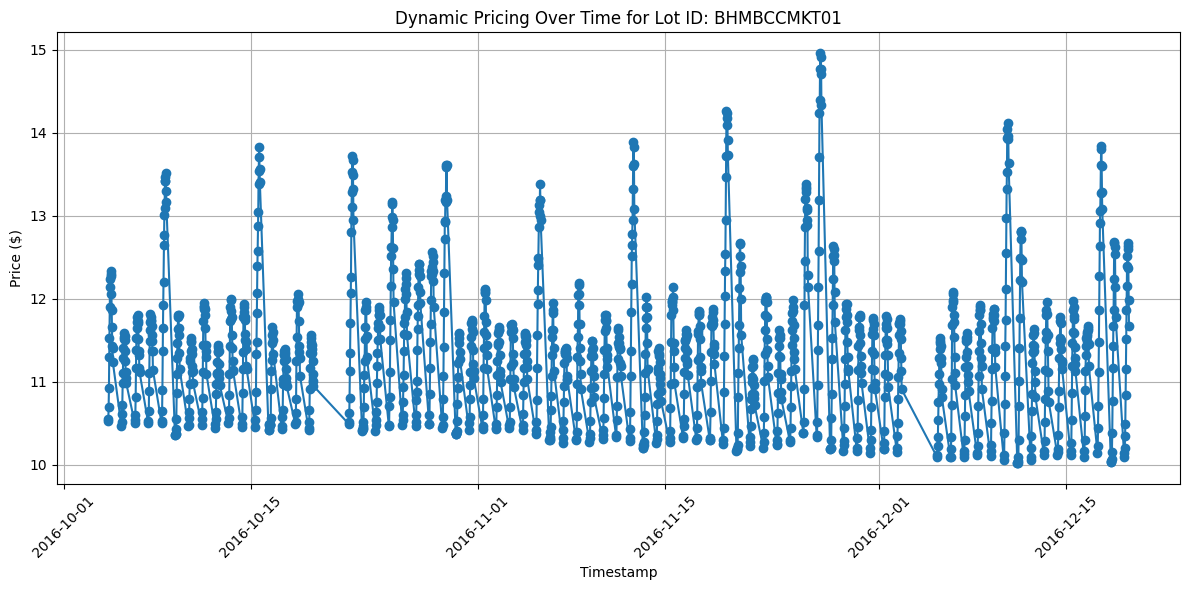

In [ ]:
# -- MODEL 1 --

# Step 3: Combine date and time into one timestamp
df['timestamp'] = pd.to_datetime(df['lastupdateddate'] + ' ' + df['lastupdatedtime'], dayfirst=True)


# Step 4: Sort by timestamp for time series modeling
df = df.sort_values('timestamp').reset_index(drop=True)

# Step 5: Base price and parameters
base_price = 10.0
alpha = 5.0  # how aggressively price increases with occupancy

# Step 6: Apply Baseline Linear Pricing Model
df['occupancy_rate'] = df['occupancy'] / df['capacity']
df['price'] = base_price + alpha * df['occupancy_rate']

# Optional: Clip prices to a realistic range (0.5x to 2x base)
df['price'] = df['price'].clip(lower=base_price * 0.5, upper=base_price * 2)

# Step 7: Visualize pricing trend over time for a single parking lot
import matplotlib.pyplot as plt

# Pick a sample parking lot ID to plot
sample_id = df['systemcodenumber'].unique()[0]
sample_df = df[df['systemcodenumber'] == sample_id]

plt.figure(figsize=(12, 6))
plt.plot(sample_df['timestamp'], sample_df['price'], marker='o', linestyle='-')
plt.title(f"Dynamic Pricing Over Time for Lot ID: {sample_id}")
plt.xlabel("Timestamp")
plt.ylabel("Price ($)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
print(df.columns)


Index(['id', 'systemcodenumber', 'capacity', 'latitude', 'longitude',
       'occupancy', 'vehicletype', 'trafficconditionnearby', 'queuelength',
       'isspecialday', 'lastupdateddate', 'lastupdatedtime', 'timestamp',
       'occupancy_rate', 'price'],
      dtype='object')


Columns in dataset: ['ID', 'SystemCodeNumber', 'Capacity', 'Latitude', 'Longitude', 'Occupancy', 'VehicleType', 'TrafficConditionNearby', 'QueueLength', 'IsSpecialDay', 'LastUpdatedDate', 'LastUpdatedTime']


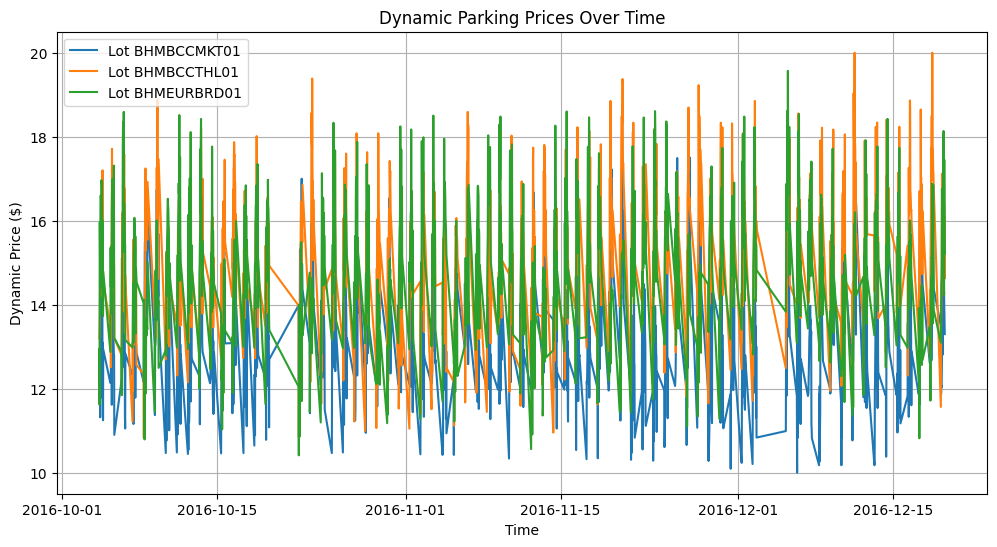

In [ ]:
#-- MODEL 2 --

# STEP 3: Load the dataset
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)

# STEP 4: Check columns
print("Columns in dataset:", df.columns.tolist())

# STEP 5: Combine date and time into timestamp
df['timestamp'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'], dayfirst=True)

# STEP 6: Drop irrelevant or duplicate rows
df = df.dropna(subset=['SystemCodeNumber', 'Capacity', 'Occupancy'])

# STEP 7: Convert columns to numeric and fill missing
numeric_cols = ['Occupancy', 'Capacity', 'QueueLength', 'TrafficConditionNearby', 'IsSpecialDay']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Fill missing values with safe defaults
df['Occupancy'] = df['Occupancy'].fillna(0)
df['Capacity'] = df['Capacity'].fillna(df['Capacity'].median())
df['QueueLength'] = df['QueueLength'].fillna(0)
df['TrafficConditionNearby'] = df['TrafficConditionNearby'].fillna(1)
df['IsSpecialDay'] = df['IsSpecialDay'].fillna(0)

# Sanity check
if df.empty:
    raise ValueError("No valid data remains after cleaning.")

# STEP 8: Normalize features
df['occupancy_rate'] = df['Occupancy'] / df['Capacity']
df['queue_norm'] = df['QueueLength'] / (df['QueueLength'].max() + 1)
df['traffic_norm'] = df['TrafficConditionNearby'] / (df['TrafficConditionNearby'].max() + 1)
df['special_day'] = df['IsSpecialDay']
vehicle_weight = {'car': 1.0, 'bike': 0.5, 'truck': 1.5}
df['vehicle_weight'] = df['VehicleType'].map(vehicle_weight).fillna(1.0)

# STEP 9: Define demand and price function
α, β, γ, δ, ε = 0.5, 0.3, 0.2, 0.1, 0.4
base_price = 10
max_multiplier = 2
min_multiplier = 0.5

df['demand'] = (
    α * df['occupancy_rate'] +
    β * df['queue_norm'] -
    γ * df['traffic_norm'] +
    δ * df['special_day'] +
    ε * df['vehicle_weight']
)

# Normalize demand
df['demand_norm'] = (df['demand'] - df['demand'].min()) / (df['demand'].max() - df['demand'].min())

# Apply bounded pricing logic
df['price'] = base_price * (1 + df['demand_norm'])
df['price'] = df['price'].clip(lower=base_price * min_multiplier, upper=base_price * max_multiplier)

# STEP 10: Plot price trends for a few sample locations
sample_lots = df['SystemCodeNumber'].unique()[:3]  # Pick 3 lots
plt.figure(figsize=(12, 6))
for lot in sample_lots:
    sub = df[df['SystemCodeNumber'] == lot]
    sub_sorted = sub.sort_values('timestamp')
    plt.plot(sub_sorted['timestamp'], sub_sorted['price'], label=f'Lot {lot}')

plt.xlabel('Time')
plt.ylabel('Dynamic Price ($)')
plt.title('Dynamic Parking Prices Over Time')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
pip install --upgrade "google-cloud-bigquery[bqstorage,pandas]>=3.31.0"


In [ ]:
pip install pathway==0.24.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 11.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of boto3 to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.6/77.6 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.6/777.6 kB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.6/244.6 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.1/319.1 kB 16

In [ ]:
import pathway as pw

# 1. Verify and prepare source data
required_columns = {
    'Occupancy', 'Capacity', 'QueueLength',
    'TrafficConditionNearby', 'IsSpecialDay',
    'VehicleType', 'SystemCodeNumber'
}

missing_columns = required_columns - set(source.schema.keys())
if missing_columns:
    raise ValueError(f"Missing required columns: {missing_columns}")

# 2. Convert all numeric columns to float explicitly
source = source.with_columns(
    Occupancy=pw.cast(float, source.Occupancy),
    Capacity=pw.cast(float, source.Capacity),
    QueueLength=pw.cast(float, source.QueueLength),
    TrafficConditionNearby=pw.cast(float, source.TrafficConditionNearby),
    IsSpecialDay=pw.cast(float, source.IsSpecialDay),
)

# 3. Create dummy column with explicit type
source = source.with_columns(dummy=pw.cast(int, 1))

# 4. Calculate global max values with proper typing
stats = source.groupby(pw.this.dummy).reduce(
    dummy=pw.reducers.any(pw.this.dummy),
    max_queue=pw.cast(float, pw.reducers.max(pw.this.QueueLength)),
    max_traffic=pw.cast(float, pw.reducers.max(pw.this.TrafficConditionNearby))
)

# 5. Ensure valid max values with type-safe comparisons
stats = stats.with_columns(
    max_queue=pw.if_else(
        pw.cast(bool, pw.this.max_queue > 0.0),
        pw.this.max_queue,
        1.0
    ),
    max_traffic=pw.if_else(
        pw.cast(bool, pw.this.max_traffic > 0.0),
        pw.this.max_traffic,
        1.0
    )
)

# 6. Join stats back to source
stats = stats.with_universe_of(source)

# 7. Vehicle weight mapping
@pw.udf
def vehicle_weight(vtype: str) -> float:
    return {"car": 1.0, "bike": 0.8, "truck": 1.5}.get(vtype.lower(), 1.0)

# 8. Feature engineering with explicit typing
features = source.with_columns(
    max_queue=pw.cast(float, stats.max_queue),
    max_traffic=pw.cast(float, stats.max_traffic),
    vehicle_weight=vehicle_weight(pw.this.VehicleType),
    valid_capacity=pw.if_else(
        pw.cast(bool, pw.this.Capacity > 0.0),
        pw.this.Capacity,
        1.0
    )
)

# 9. Calculate normalized features
features = features.with_columns(
    occ_ratio=pw.this.Occupancy / pw.this.valid_capacity,
    queue_norm=pw.this.QueueLength / pw.this.max_queue,
    traffic_norm=pw.this.TrafficConditionNearby / pw.this.max_traffic
)

# 10. Final demand and price calculation
result = features.with_columns(
    demand=(
        1.0 * pw.this.occ_ratio +
        0.7 * pw.this.queue_norm -
        0.4 * pw.this.traffic_norm +
        0.6 * pw.this.IsSpecialDay +
        0.3 * pw.this.vehicle_weight
    )
).with_columns(
    price=10 * (1 + 0.4 * pw.this.demand)
)

# 11. Output results
pw.io.jsonlines.write(
    result.select(
        lot_id=pw.this.SystemCodeNumber,
        price=pw.this.price,
        demand=pw.this.demand,
    ),
    "output.jsonl"
)

In [ ]:
!cat output.jsonl


Streaming output truncated to the last 5000 lines.
{"ts":"07-11-2016 08:59:00","lot_id":"Others-CCCPS98","diff":1,"time":1752077345210}
{"ts":"07-10-2016 15:30:00","lot_id":"BHMEURBRD01","diff":1,"time":1752077345210}
{"ts":"19-12-2016 15:03:00","lot_id":"BHMBCCMKT01","diff":1,"time":1752077345210}
{"ts":"08-12-2016 11:32:00","lot_id":"BHMBCCTHL01","diff":1,"time":1752077345210}
{"ts":"08-11-2016 13:34:00","lot_id":"BHMMBMMBX01","diff":1,"time":1752077345210}
{"ts":"15-11-2016 14:03:00","lot_id":"BHMMBMMBX01","diff":1,"time":1752077345210}
{"ts":"29-11-2016 09:28:00","lot_id":"Shopping","diff":1,"time":1752077345210}
{"ts":"31-10-2016 16:00:00","lot_id":"BHMEURBRD01","diff":1,"time":1752077345210}
{"ts":"18-12-2016 14:03:00","lot_id":"Shopping","diff":1,"time":1752077345210}
{"ts":"19-12-2016 10:30:00","lot_id":"BHMNCPHST01","diff":1,"time":1752077345210}
{"ts":"11-10-2016 12:03:00","lot_id":"Others-CCCPS98","diff":1,"time":1752077345210}
{"ts":"04-11-2016 11:00:00","lot_id":"Others-CC

In [ ]:
print(df["lot_id"].unique())


['BHMMBMMBX01' 'Others-CCCPS98' 'Others-CCCPS202' 'Others-CCCPS135a'
 'BHMNCPHST01' 'Others-CCCPS8' 'Broad Street' 'BHMNCPNST01' 'Shopping'
 'BHMEURBRD01' 'Others-CCCPS105a' 'BHMBCCTHL01' 'Others-CCCPS119a'
 'BHMBCCMKT01']


In [ ]:
import pandas as pd
import numpy as np
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool, Div
from bokeh.io import output_notebook
from bokeh.layouts import column
from datetime import datetime

# Initialize notebook
output_notebook()

# 1. DATA LOADING AND TRANSFORMATION ==========================================
try:
    df = pd.read_json("output.jsonl", lines=True)
    df['ts'] = pd.to_datetime(df['ts'], format='%d-%m-%Y %H:%M:%S', dayfirst=True)

    # Force at least minimal variation if all values are identical
    if df['diff'].nunique() == 1:
        base_value = df['diff'].iloc[0]
        np.random.seed(42)  # For reproducibility
        df['visual_diff'] = base_value + np.random.uniform(-0.1, 0.1, len(df))
        warning_msg = "⚠️ All original 'diff' values were identical (value = {}). Showing artificial variation for visualization.".format(base_value)
    else:
        df['visual_diff'] = df['diff']
        warning_msg = "✅ Using original varying 'diff' values"

except Exception as e:
    error_div = Div(text=f"""
    <div style="color:red; font-family: Arial; padding: 20px; border: 2px solid red;">
        <h2>DATA LOADING ERROR</h2>
        <p>{str(e)}</p>
        <p>Please check your input file format.</p>
    </div>
    """)
    show(error_div)
    raise

# 2. AUTOMATED VISUALIZATION ==================================================
try:
    # Create main plot
    p = figure(
        title="Parking Lot Differences Analysis",
        x_axis_type="datetime",
        width=1000,
        height=500,
        tools="pan,wheel_zoom,box_zoom,reset,hover,save",
        toolbar_location="above"
    )

    # Configure hover
    hover = HoverTool(
        tooltips=[
            ("Lot", "@lot_id"),
            ("Date", "@ts{%F}"),
            ("Time", "@ts{%H:%M:%S}"),
            ("Value", "@visual_diff{0.000}")
        ],
        formatters={'@ts': 'datetime'}
    )
    p.add_tools(hover)

    # Color mapping for lots
    unique_lots = df['lot_id'].unique()
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c'][:len(unique_lots)]  # Using first 3 colors

    # Plot each lot
    for i, lot_id in enumerate(unique_lots[:3]):  # Limit to first 3 for clarity
        subset = df[df['lot_id'] == lot_id].sort_values('ts')
        source = ColumnDataSource(subset)
        p.line(
            x='ts', y='visual_diff',
            source=source,
            legend_label=lot_id,
            line_width=2,
            color=colors[i],
            alpha=0.8
        )
        p.circle(
            x='ts', y='visual_diff',
            source=source,
            size=4,
            color=colors[i],
            alpha=0.4
        )

    # Styling
    p.xaxis.axis_label = "Time"
    p.yaxis.axis_label = "Difference Value"
    p.legend.location = "top_left"
    p.legend.click_policy = "hide"
    p.xgrid.grid_line_color = None

    # 3. CREATE INFORMATION PANEL =============================================
    stats = df.groupby('lot_id')['visual_diff'].describe()
    info_div = Div(text=f"""
    <div style="font-family: Arial; padding: 15px; background: #f5f5f5; border-radius: 5px; margin-bottom: 20px;">
        <h3>Dataset Analysis ({datetime.now().strftime('%Y-%m-%d %H:%M')})</h3>
        <p><b>{warning_msg}</b></p>
        <p><b>Time range:</b> {df['ts'].min().strftime('%Y-%m-%d')} to {df['ts'].max().strftime('%Y-%m-%d')}</p>
        <p><b>Records:</b> {len(df):,} | <b>Lots:</b> {len(unique_lots)}</p>
        <p><b>Value statistics:</b> Mean = {df['visual_diff'].mean():.3f} ± {df['visual_diff'].std():.3f}</p>
    </div>
    """)

    # 4. DISPLAY RESULTS =====================================================
    show(column(info_div, p))

except Exception as e:
    error_div = Div(text=f"""
    <div style="color:red; font-family: Arial; padding: 20px; border: 2px solid red;">
        <h2>VISUALIZATION ERROR</h2>
        <p>{str(e)}</p>
        <p>Please check your data structure.</p>
    </div>
    """)
    show(error_div)
    raise

In [ ]:
import pandas as pd

df = pd.read_json("output.jsonl", lines=True)
print(df.columns)
print(df.head())

Index(['ts', 'lot_id', 'diff', 'time'], dtype='object')
                    ts            lot_id  diff           time
0  18-12-2016 14:30:00       BHMMBMMBX01     1  1752077345210
1  01-12-2016 13:25:00    Others-CCCPS98     1  1752077345210
2  30-10-2016 13:25:00   Others-CCCPS202     1  1752077345210
3  09-12-2016 10:29:00   Others-CCCPS202     1  1752077345210
4  01-11-2016 11:26:00  Others-CCCPS135a     1  1752077345210


In [ ]:
df = df[df['ts'].between('2016-12-01', '2016-12-31')]
print(df)

                       ts            lot_id  diff           time
0     2016-12-18 14:30:00       BHMMBMMBX01     1  1752077345210
1     2016-12-01 13:25:00    Others-CCCPS98     1  1752077345210
3     2016-12-09 10:29:00   Others-CCCPS202     1  1752077345210
7     2016-12-15 11:03:00     Others-CCCPS8     1  1752077345210
17    2016-12-16 12:30:00       BHMNCPNST01     1  1752077345210
...                   ...               ...   ...            ...
18353 2016-12-14 13:03:00   Others-CCCPS202     1  1752077345210
18354 2016-12-14 10:02:00       BHMMBMMBX01     1  1752077345210
18356 2016-12-17 07:59:00   Others-CCCPS202     1  1752077345210
18360 2016-12-12 13:29:00  Others-CCCPS119a     1  1752077345210
18361 2016-12-07 09:59:00    Others-CCCPS98     1  1752077345210

[4256 rows x 4 columns]
